# SLT-CE-1: Sampling

In this coding exercise we will test various Markov Chain Monte Carlo (MCMC)
 sampling procedures [1] introduced during the lecture. We will first tackle
 the image reconstruction problem followed by the traveling salesman problem.

## Background (image reconstruction problem)


Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one
 needs to recover the original through denoising. To do so we will use the
 prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from
 physics as explained in section 8.3.3 of [2]. An undirected graphical
 model is designed to model (i) the adherence of the reconstruction to the
 observed noisy image and (ii) the correlation between neighboring pixels.
 We are interested in recovering a single image, the most likely one, with
 respect to the underlying distribution i.e. we do MAP inference to discover
  the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 
[0] [SLT ](https://ml2.inf.ethz.ch/courses/slt/)

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is
the value of the i-th pixel, the Ising model tries to find a denoised image
$x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x|y) = - \frac{\beta}{2} \sum_{i} \frac{x_i}{\lvert N_i\rvert}\sum_{j \in N_i} x_j - \mu \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel
neighbourhood $N_i$ usually involves $\lvert N_i\rvert=$ 4 or 8 surrounding
pixels. In this exercise we consider only the 4 pixel neigbourhood (up,
down, left and right pixels). The undirected probabilistic graphical model
from where the energy function $E(x|y)$ is derived, is explained in more
detail in [2]. Note that $\beta$ denotes the interaction between pixels and is
not to be mistaken for the inverse temperature, which sometimes is also
denoted as $\beta$.

 <h2> Setup </h2>

We start by importing necessary python packages.

In [2]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time

from skimage.transform import resize
from scipy.signal import fftconvolve
from sklearn.metrics import hamming_loss

from scipy.optimize import minimize_scalar

# Windows users might experience issues with pathos multiprocessing. 
# We only use pathos to accelerate the last cell of section 5.5
# If you are unable to install pathos, you can simply remove the two 
# lines below and modify the code in the last cell of section 5.5 
# to run in a single process.
from multiprocessing import cpu_count
from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_images(size=None, p=0.3):
    """Load image data for denoising
    
    Args:
        size (tuple): image size, default (300,300)
        p (float): noise fraction in [0,1]
        
    Returns:
        noisy: noisy image
        img: ground truth image
    """
    img = mpimg.imread("eth.png")[:,:,0] # Load image

    # Binarize image
    img[img > 0.5] = 1
    img[img <= 0.5] = -1
    
    # Resize image 
    if size is not None:
        img = resize(img, size)
        img[img > 0] = 1
        img[img <= 0] = -1
    
    np.random.seed(13)

    flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

    noisy = flip * img
    
    return noisy, img

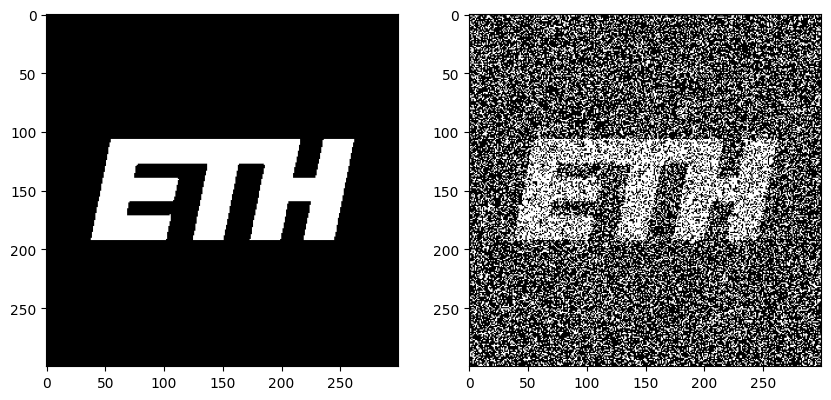

In [4]:
noisy, img = get_images()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(noisy,cmap='gray')
plt.show()

<h2 style="-color:#0;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#0;">
Shortly describe the following sampling procedures, and provide the key formulas. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Metropolis**: Suppose that we want to draw samples from a distribution $p(x)$ and that $\tilde{p}(x)$ is a known function, proportional to $p$. Assume furthermore that we are able to draw samples from a *proposal distribution* $q(x)$, which is symmetric, i.e. $q(x | y) = q(y | x)$ for all $x$ and $y$ (in the support of $q$) and such that the support of $q$ includes the support of $p$.

**Algorithm:**
1. Initialize $z^1$.
2. At stage $\tau \geq 1$, draw a sample $z^*$ from the distribution $z^* \sim q(z^*|z^\tau)$.
3. Calculate the *acceptance ratio* 
$$A(z^*, z^\tau) = min\left(1, \frac{\tilde{p}(z^*)}{{\tilde{p}(z^\tau)}}\right).$$
4. Generate a sample $u$ from a uniform distribution on $[0,1]$.
5. If $u \leq A(z^*, z^\tau)$, accept the sample $z^*$; set $z^{\tau+1} = z^*$. Otherwise, reject the sample; discard $z^*$ and set $z^{\tau+1} = z^{\tau}$. Note that the acceptence ratio corresponds to the probability of accepting $z^*$.
6. Repeat from step 2 at stage $\tau+1$.

- **Metropolis-Hastings**: The Metropolis-Hastings algorithm is a generlisation of the Metropolis algorithm where $q$ need not be symmetric and 
$$A(z^*, z^\tau) = min\left(1, \frac{\tilde{p}(z^*)q(x^\tau | x^*)}{{\tilde{p}(z^\tau)q(x^* | x^\tau)}}\right).$$

- **Simulated Annealing**: Suppose instead that we want to estimate a global maximum of a distribution $p(x)$. The idea is to accomplish this by, at step $i$, using $p^{1/T_i}$ as the target distribution in the Metropolis-Hastings algortihm, where $(T_i)_{\tau\geq 1}$ is a *cooling schedule* such that $\lim_{\tau\to\infty}T_i = 0$. The algorithm has the same requirements as the Metropolis-Hastings algorithm and the steps follow.

**Algorithm:**
1. Initialize $z^1$ and set $T_1 = 0$.
2. At stage $\tau \geq 1$, draw a sample $z^*$ from the distribution $z^* \sim q(z^*|z^\tau)$.
3. Calculate the *acceptance ratio* 
$$A(z^*, z^\tau) = min\left(1, \frac{\tilde{p}^{1/T_\tau}(z^*)q(x^\tau | x^*)}{{\tilde{p}^{1/T_\tau}(z^\tau)q(x^* | x^\tau)}}\right).$$
4. Generate a sample $u$ from a uniform distribution on $[0,1]$.
5. If $u \leq A(z^*, z^\tau)$, accept the sample $z^*$; set $z^{\tau+1} = z^*$. Otherwise, reject the sample; discard $z^*$ and set $z^{\tau+1} = z^{\tau}$.
6. Repeat from step 2 at stage $\tau+1$.

<p style="background-color:#0;">
    Implement the energy function introduced in the model section of the notebook.<br>
    <b> (!)</b> Deliberately implement a naive solution, which explicitly performs (nested) loops to compute the sums. 
    </p>

In [5]:
def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', which corresponds to the vector y in the model.

    Args:
        img_estimate (np.ndarray): estimated image matrix
        img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
        energy (float): energy of the estimate given observation
    """
    height = img_estimate.shape[0]
    width = img_estimate.shape[1]
    
    E = 0
    for i in range(height):
        for j in range(width):
            
            # get neighbours
            neighbours = [img_estimate[i+k][j] for k in [-1, 1] if i+k > -1 and i+k < height] + \
            [img_estimate[i][j+k] for k in [-1, 1] if j+k > -1 and j+k < width]
            
            # add first part of formula
            E -= beta/2*img_estimate[i][j]/4*np.sum(neighbours)
            
            # add second part of formula
            E -= mu*img_estimate[i][j]*img_noisy_observation[i][j]
    
    return E 

<p style="background-color:#0;">Make sure to get the correct result:</p>

In [6]:
assert np.isclose(energy(*get_images()), -146559.5) or np.isclose(energy(*get_images()), -146934.5)

<p style="background-color:#0;">Implement metropolis sampling.<br>
<b>(!)</b> Deliberately implement a naive solution, which loops over each pixel, attempts a flip, measures the energy before and after, and then decides whether to accept the flip, or not. Use the naive energy function from before.
</p>

In [7]:
def metropolis(img_noisy_observation, epochs, T=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using energy.

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of the simulation

    Returns:
        estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()

    current_energy = energy(noisy_img, estimate)
    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(current_energy)
        
        for cnt, idx in enumerate(np.random.permutation(n_pixels)):
                        
            # print progress
            print("Finished {:6.2f}% of epoch {}".format((cnt+1)/n_pixels * 100, e+1), end="\r")
            
            # index of considered pixel
            i, j = idx // width, idx % width 
            
            # flip the considered pixel
            estimate[i][j] *= -1
        
            # calculate candidate energy
            candidate_energy = energy(noisy_img, estimate)
            
            # calculate acceptance ratio
            acceptance_ratio = np.exp((1/T)*(current_energy-candidate_energy))
                        
            # draw a uniform random sample for comparison
            u = np.random.uniform()
            
            # accept or reject candidate
            if u <= acceptance_ratio:
                current_energy = candidate_energy
            else:
                estimate[i][j] *= -1
    
        energies.append(current_energy)
        
    return estimate, np.asarray(energies)

<p style="background-color:#0;">
    Evaluate your implemented metropolis algorithm, using the provided evaluation function.<br>
    The energy should decrease over epochs. The reconstructed image should be a denoised version of the noisy image.
    </p>

In [8]:
def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
        method (function pointer): sampling method
        img_noisy_observation (np.ndarray): noisy image matrix
        img_original (np.ndarray): original image matrix
        epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
        T (float): The positive temperature of the simulation
    """

    start_time = time.time()
    img_estimate, energies = method(img_noisy_observation, epochs, T)
    execution_time = time.time() - start_time

    if not surpress:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

        ax1.plot(energies, marker="x")
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('energy')

        ax2.imshow(img_estimate, cmap='gray')
        ax2.set_title('Reconstruction')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

        ax3.imshow(img_noisy_observation, cmap='gray')
        ax3.set_title('Input')
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

        plt.show()
    
    return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())

<p style="background-color:#0;">
    The naive implementation is incredibly slow, so we use a downsampled image for evaluation.
</p>

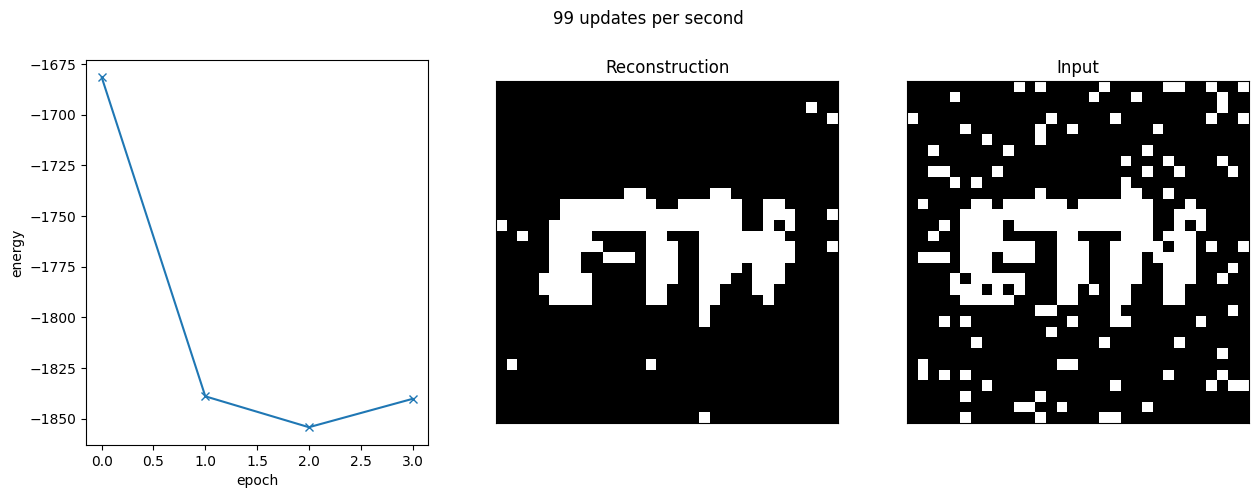

In [9]:
E_metro = evaluate_ising(metropolis, *get_images(size=(32,32), p=0.1), epochs=3)

<h2 style="background-color:#0;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#0;">
We are now considering a different problem. We want to solve the <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem">traveling salesman problem</a> for N=532 major cities in the USA.
</p>

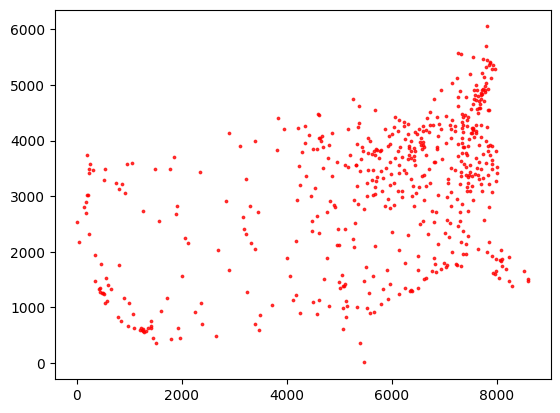

In [33]:
coordinates = pd.read_csv("cities.csv", names=['x', 'y'], sep=';', index_col=False)
coordinates = np.asarray(coordinates)  # Nx2 array containing the coordiantes of the cities
plt.scatter(coordinates[:,0], coordinates[:,1], s=3, c="r", alpha=0.75)
plt.show()

<p style="background-color:#0;">
Implement the distance function for the TSP:
</p>

In [482]:

def distance(coordinates, route=None):
    """Calculate travel distance.
    
    If no route is given, assumes that coordinates are travelled in order,
    starting at the first entry, and connecting the last entry again with the first.
    
    Args:
        coordinates (np.ndarray): route coordinates (assume in units of meters)
        route: permutation of coordinate order
        
    Returns:
        float: traveled distance in units of kilometers
    """
      
    if route is not None:
        coordinates = coordinates[route]
           
    diff = np.roll(coordinates, -1, axis=0) - coordinates 
    dist = np.sum([np.sqrt(d[0]**2+d[1]**2) for d in diff]) / 1000
    
        
    return dist

<p style="background-color:#0;">
Make sure it returns the correct value:
</p>

In [64]:
assert np.isclose(distance(coordinates), 978.3514183630234)

In [65]:
def evaluate_tsp(method, coordinates, epochs=1):
    """Evaluate sampling method on coordinates
    
    Args:
        method (function pointer): sampling method
        coordinates (np.ndarray): city coordinates, shape Nx2
        epochs (int): number of epochs to run the sampling
    """
    np.random.seed(7)
    N = coordinates.shape[0]
    route = np.random.permutation(N)
 
    start_time = time.time()
    route, distances = method(coordinates, route, epochs)
    execution_time = time.time() - start_time

    if not (np.sort(route) == range(N)).all():
        raise ValueError("Returned route is not valid!")

    x, y = coordinates[route, 0], coordinates[route, 1]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(distances, marker="o", markersize=3)
    plt.plot([0, len(distances)], [27686/1000,27686/1000], c="green") # best known solution
    plt.grid(axis="y")
    
    plt.subplot(122, xticks=[], yticks=[])
    plt.plot(x, y, alpha=0.5, c="blue", marker="o", markerfacecolor="red", markersize=3, linewidth=1)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], alpha=0.5, c="blue", linewidth=1)
    
    plt.show()

First, solve the traveling salesman problem with metropolis, and then with simulated annealing. <br>
We consider all permutations of $(1,\dots,N)$ as the solution space, so one route corresponds to one permutation. <br>
As proposals use transpositions instead of pixel flips. <br>
More precisely, pick a random index $i$, and exchange it with its successor, i.e. $(x_1,\dots,x_i, x_{i+1},\dots,x_N) \rightarrow (x_1,\dots,x_{i+1}, x_{i},\dots,x_N)$.<br>
    Keep in mind, that TSP goes in a cycle, so the successor of N is 1.

In [87]:
def metropolis_tsp(coordinates, route=None, epochs=1, T=1):
    """Metropolis for TSP

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        epochs (int): number of loops through all cities.
        T (float): Temperature of simulation

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))
    for e in range(epochs):
        for cnt, idx in enumerate(np.random.permutation(N)):
                        
            # print progress
            print("Finished {:6.2f}% of epoch {}".format((cnt+1)/N * 100, e+1), end="\r")
                        
            # calculate current distance
            current_distance = distance(coordinates, route)
            
            # transpose the considered index
            route[idx], route[(idx+1) % N] = route[(idx+1) % N], route[idx]
        
            # calculate candidate energy
            candidate_distance = distance(coordinates, route)
            
            # calculate acceptance ratio
            acceptance_ratio = np.exp((1/T)*(current_distance-candidate_distance))
                        
            # draw a uniform random sample for comparison
            u = np.random.uniform()
            
            # accept or reject candidate
            if u <= acceptance_ratio:
                current_distance = candidate_distance
            else:
                route[idx], route[(idx+1) % N] = route[(idx+1) % N], route[idx]
            
                
        
        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#0;">
Evaluate your metropolis algorithm for the traveling salesman problem.
</p>

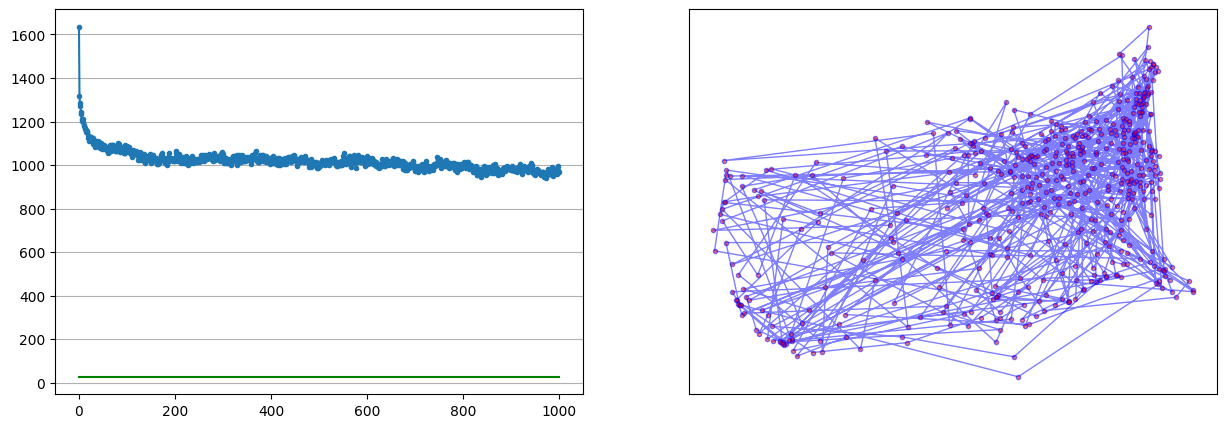

In [617]:
evaluate_tsp(metropolis_tsp, coordinates, epochs=1000)

In [613]:
def simulated_annealing(coordinates, route=None, epochs=1, T=20.0, eta=0.995):
    """Simulated Annealing for TSP

    T(n) = T * eta**n

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        route (array): inital route
        epochs (int): number of loops through all cities.
        T (float): Initial temperature
        eta (float): Exponential cooling rate

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    current_distance = distance(coordinates, route)
    distances.append(current_distance)

    for e in range(epochs):
        
        for cnt, idx in enumerate(np.random.permutation(N)):
                        
            # print progress
            print("Working on epoch {}...".format(e+1), end="\r")
                        
            # calculate current distance
            current_distance = distance(coordinates, route)
            
            # transpose the considered index
            route[idx], route[(idx+1) % N] = route[(idx+1) % N], route[idx]
        
            # calculate candidate energy
            candidate_distance = distance(coordinates, route)
            
            # calculate acceptance ratio
            acceptance_ratio = np.exp((1/T)*(current_distance-candidate_distance))
            
            
            # draw a uniform random sample for comparison
            u = np.random.uniform()
            
            # accept or reject candidate
            if u <= acceptance_ratio:
                current_distance = candidate_distance
            else:
                route[idx], route[(idx+1) % N] = route[(idx+1) % N], route[idx]
                
            # update T 
            T *= eta  
        distances.append(current_distance)

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#0;">
Evaluate your simulated annealing algorithm for the traveling salesman problem.
</p>

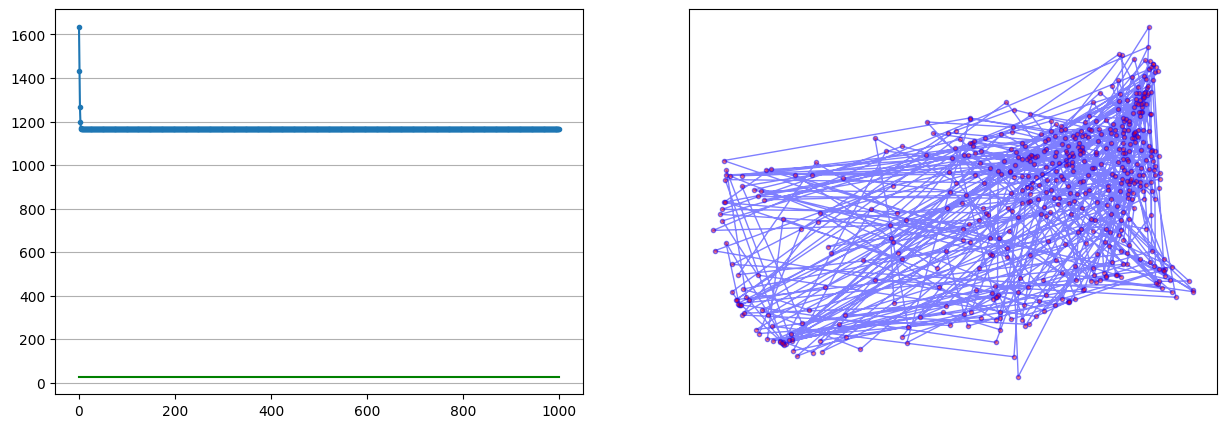

In [618]:
evaluate_tsp(simulated_annealing, coordinates, epochs=1000)

<h2 style="background-color:#0;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#0;">
    Optimize the calculation of the naive metropolis for the Ising problem by taking into account that the energy change caused by a single flip depends only on the affected pixel's value, and its neighborhood.<br>
    More precisely, implement the function local_energy_change, and use it in the method local_metropolis.
</p>

In [10]:
def local_energy_change(noisy, estimate, i, j, beta, mu):
    """
    
    Local energy difference between unflipped and flipped pixel i,j 
    
    Args:
        noisy: noisy reference image
        estimate: current denoising estimate
        i,j: Position of pixel
    
    Returns:
        float: local energy difference when pixel i,j is flipped 
    """
    height = estimate.shape[0]
    width = estimate.shape[1]
    
    # neighbours indices for (i,j)
    neighbours = [estimate[i+k][j] for k in [-1, 1] if i+k > -1 and i+k < height] + \
            [estimate[i][j+k] for k in [-1, 1] if j+k > -1 and j+k < width]
            
        
    
            
    dE = beta/2*estimate[i][j]*np.sum(neighbours) + 2*mu*estimate[i][j]*noisy[i][j]

    return dE

def local_metropolis(img_noisy_observation, epochs, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using local_energy_change 

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    current_energy = energy(noisy_img, estimate)

    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(current_energy)
        
        for idx in np.random.permutation(n_pixels):
            
            # index of considered pixel
            i, j = idx // width, idx % width
                    
            # calculate (local) energy change
            dE = local_energy_change(noisy_img, estimate, i, j, beta, mu)  
             
            # calculate acceptance ratio
            acceptance_ratio = np.exp(-(1/T)*dE)
                        
            # draw a uniform random sample for comparison
            u = np.random.uniform()
            
            # accept or reject candidate
            if u <= acceptance_ratio:
                estimate[i][j] *= -1
        
        # print progress
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#0;">
    We run two evaluations, one for the small image, and one on the full image.
    </p>

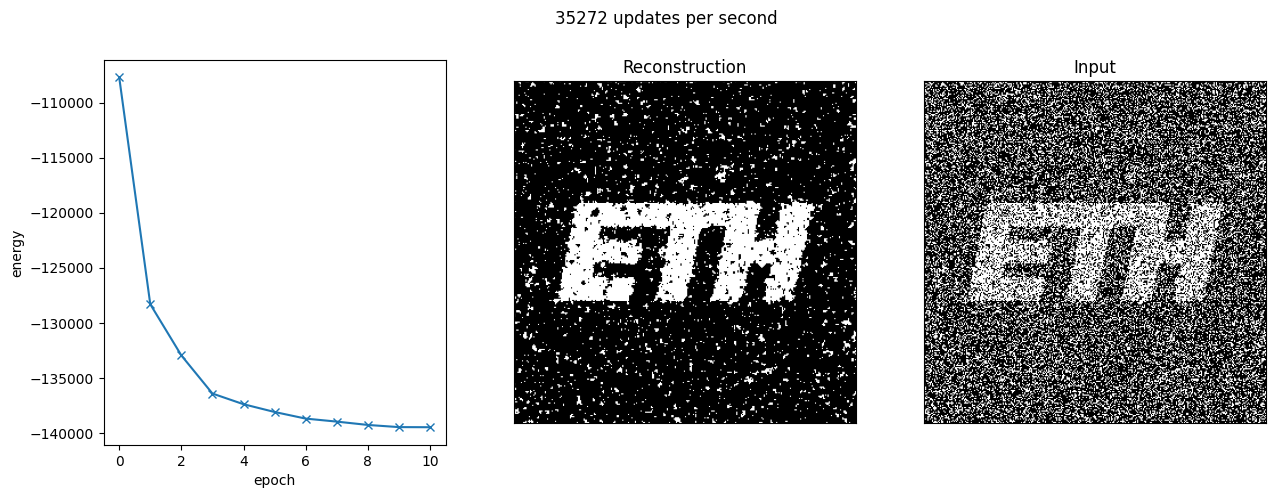

(-139494.25, 0.07093333333333333)

In [11]:
E_local = evaluate_ising(local_metropolis, *get_images(size=(32,32), p=0.1), epochs=3, surpress=True);
evaluate_ising(local_metropolis, *get_images(), epochs=10)

<p style="background-color:#0;">
    Make sure, metropolis and local_metropolis are equivalent:
    </p>

In [12]:
assert E_metro == E_local

<h2 style="background-color:#0;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#0;">
    We can speed up metropolis for the Ising model even further by using vectorized operations, i.e. using operations on arrays instead of looping over pixels.<br>
    Implement checkerboard_metropolis, which alternatingly updates two independent sub-grids at once.
    Your final code must have only one for-loop, namely over epochs (not counting the loop over the two grids). Use fftconvolve to compute the neighborhood term of the energy difference.
    </p>

In [325]:
def checkerboard_energy_change(noisy_img, estimate, grid, beta, mu):
    """Compute energy change when flipping pixels in grid
    
    When using the 4-neighborhood, a 2D image can be separated in two
    independent grids, hence the name checkerboard.
    All the pixels in one grid can be updated simultaneously, because they
    are independent. Using this property, we can improve computational
    efficiency by using vectorized operations instead of loops.
    
    Args:
        noisy_img: Noisy reference image
        estimate: Current image reconstruction
        grid: Flat array or list of grid indices.
    
    Returns:
        numpy.array: Energy change for each pixel in grid,
            same size as grid.
    
    """
    
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])
        
    dE = beta/2*fftconvolve(estimate, kernel, 'same')*estimate*grid + 2*mu*estimate*grid*noisy_img
    
    return dE
    
    

In [446]:
def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    Alternatingly update two independent grids

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number

    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    
    grid_1 = np.zeros(noisy_img.shape)
    grid_1[1::2, ::2], grid_1[::2, 1::2] = 1, 1
    grid_2 = 1 - grid_1
        
    grids = [grid_1, grid_2]
    
    current_energy = energy(noisy_img, estimate)
    
    energies = []
    for e in range(epochs):
                
        if e == 0:
            energies.append(current_energy)
        
        for grid in grids:
            
            # calculate (local) energy change
            dE = checkerboard_energy_change(noisy_img, estimate, grid, beta, mu)  
             
            # calculate acceptance ratio
            acceptance_ratio = np.exp(-(1/T)*dE) * grid
                                                
            # draw a uniform random sample for comparison
            u = np.random.uniform(size=noisy_img.shape)
            
            # acceptance mask
            mask = (u <= acceptance_ratio)
            
            # accept or reject candidates
            estimate *= (-2*mask+1)            
            
            # calculate new energy 
            current_energy += np.sum(dE[mask])
                
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(current_energy)
        
    return estimate, np.asarray(energies)

<p style="background-color:#0;">
    Run the checkerboard_metropolis:
    </p>

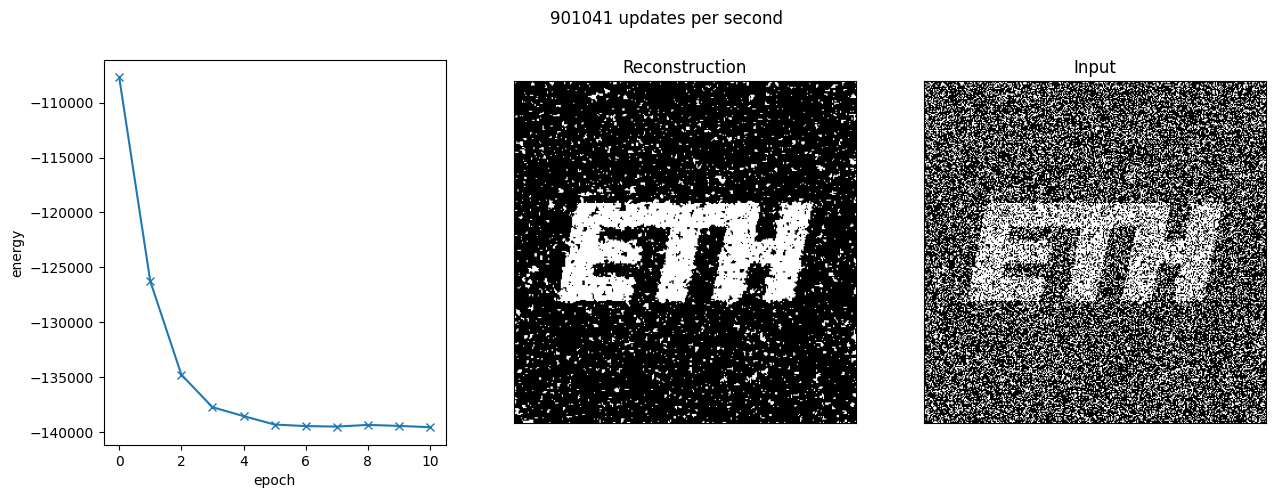

(-139542.25, 0.06765555555555555)

In [447]:
evaluate_ising(checkerboard_metropolis, *get_images(), epochs=10)

<p style="background-color:#0;">
    Run the experiment below, and explain the observed behavior!
    </p>

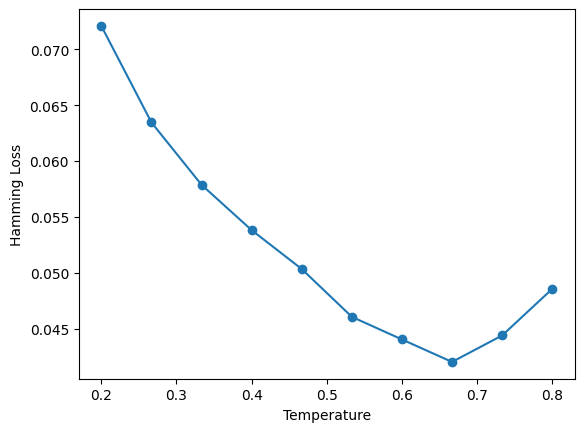

In [448]:
Trange = np.linspace(0.2,0.8,10)
loss = [evaluate_ising(checkerboard_metropolis, *get_images(), epochs=10, T=T, surpress=True)[1]
         for T in np.linspace(0.2,0.8,10)]

plt.plot(Trange, loss, marker="o")
plt.ylabel("Hamming Loss")
plt.xlabel("Temperature")
plt.show()

The graph shows the relation between the hamming loss (proportion of missclassified pixels) and the temperature. The loss decreases at first, with increasing temperature before reaching a minumum and increasing again. This showcases the tradeoff between exploration and exlpoitation. With increasing temperature, the model is allowed to explore a larger portion of the solution space, while a lower temperature makes the Gibbs distribution 'hone in' on the most promising/high likelihood areas. In other words if the temperature is too large, a big portion of samples are likely too get accepted and convergence towards a optimal solution becomes difficult. On the other hand, if the temperature is too small, new samples are unlikely to be accepted, the solution space is not explored and optimal solutions are also not found.

<p style="background-color:#0;">
Run the experiment below, and explain the observed behavior!
</p>

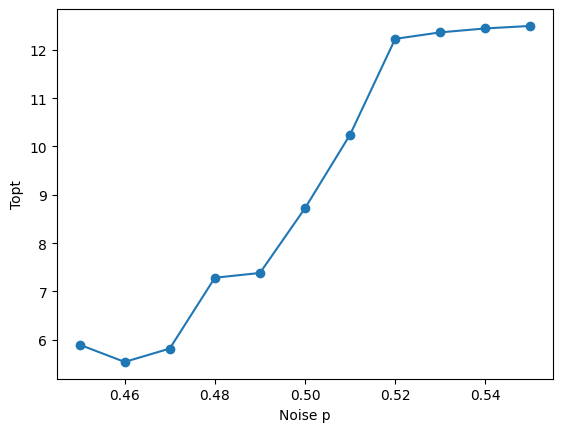

In [616]:
def find_Topt(p):
    f = lambda T: evaluate_ising(checkerboard_metropolis, *get_images(p=p), epochs=10, T=T, surpress=True)[1]
    result = minimize_scalar(f, options={"xatol": 0.001}, bounds=(0, 20), method="bounded")
    return result.x

prange = np.arange(0.45, 0.55, 0.01)
with Pool(cpu_count()) as pool:
    Topt = pool.map(find_Topt, prange)
    
plt.plot(prange, Topt, marker="o")
plt.ylabel("Topt")
plt.xlabel("Noise p")
plt.show()

The graph shows the relation between optimal values for the temperature and the level of noise in the image. We see that a larger temperature is preffered for noisier data. This is reasonable, since we would need to stray quite far away from our initial position in the solution space, in order to find an optimal solution when the original picture is noisy. On the other hand, if the intial picture is less noisy (closer to the optimal solution) a lower temperature is preffered, since it is beneficial to only explore solutions that are almost optimal, without risking getting stuck in local minima, or wasting computer power on searching in suboptimal areas.

<h2 style="background-color:#0;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

Implement a more sophisticated proposal distribution, which is more appropriate for TSP than simple transpositions. <br>
Consider your idea successful, if the travel distance goes at least below 300.<br>
Moreover, make sure that your algorithm fullfills detailed balanced by using the Metropolis-Hastings acceptance probability:<br>
    $p_{accept}=\min(\frac{p(x\rightarrow y)}{p(y\rightarrow x)}e^{-\frac{\Delta E}{T}}$, 1)


In [614]:
def myfancyalgorithm(coordinates, route=None, epochs=1, T=1, eta=0.995):

    np.random.seed(7)
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    current_distance = distance(coordinates, route)
    distances.append(current_distance)

    for e in range(epochs):
        
        for i in np.random.permutation(N):
            
            # print progress            
            
            j = np.random.randint(low=0, high=N)
            while j == i:
                j = np.random.randint(low=0, high=N)

            k, l = np.min([i,j]), np.max([i,j])
            
            print("epoch {}".format(e+1), end='\r')
                        
            # calculate candidate route
            candidate_route = route.copy()
            candidate_route[k:l] = candidate_route[k:l][::-1]    
            
        
            # calculate candidate energy
            candidate_distance = distance(coordinates, candidate_route)
            
            # calculate acceptance ratio
            acceptance_ratio = np.exp((1/T)*(current_distance-candidate_distance))
            
            # draw a uniform random sample for comparison
            u = np.random.uniform()
            
            # accept or reject candidate
            if u <= acceptance_ratio:
                current_distance = candidate_distance
                route = candidate_route
            
            # update T
            T *= eta
        distances.append(current_distance)

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#0;">
Evaluate your more sophisticated algorithm for the traveling salesman problem.
</p>

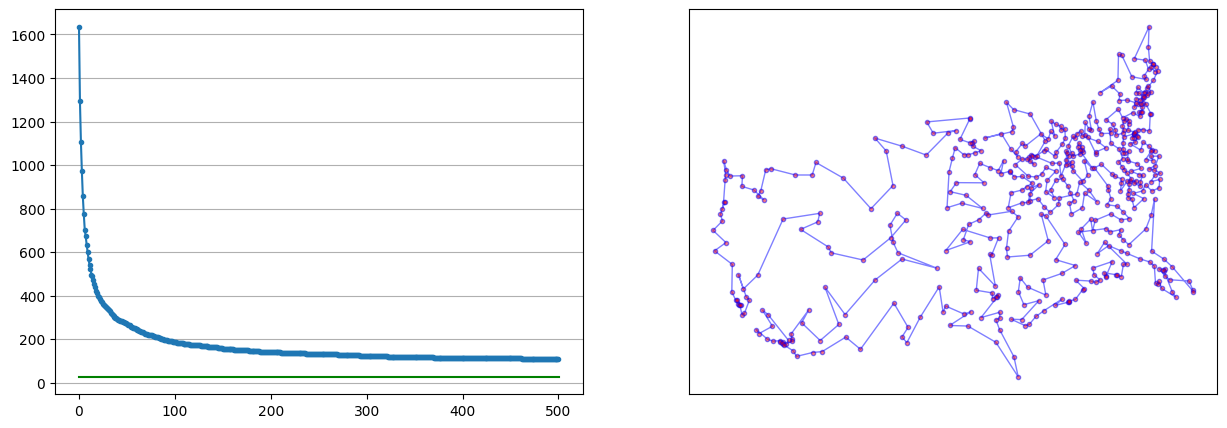

In [619]:
evaluate_tsp(myfancyalgorithm, coordinates, epochs=500)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.